# Logbook

# jld2 -> netcdf

In [11]:
import h5py
import os
import yaml
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset


def list_files_dir(directory):
    dir_path = Path(directory)
    files = [f for f in dir_path.rglob('*') if f.is_file() and f.name.endswith('.jld2')]
    return files

def p(name, obj):
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(obj[()])

def jld2_to_nc(jld2_file_path, nc_file_path, yaml_file_path):
    # ouverture des fichiers
    jl = h5py.File(jld2_file_path, 'r')
    if os.path.exists(nc_file_path):
        os.remove(nc_file_path)
    nc = Dataset(nc_file_path, 'w', format='NETCDF4')
    params = {}

    # time index/groups
    t_group = jl['timeseries']['t']
    i_t = list(t_group.keys())
    i_t = [int(i) for i in i_t]
    i_t.sort()
    i_t = [str(i) for i in i_t]
    
    # dimensions
    t = [t_group[i][()] for i in i_t]
    zw = jl['grid']['zᵃᵃᶠ'][3:-3]
    zr = jl['grid']['zᵃᵃᶜ'][3:-3]
    nc.createDimension('t', len(i_t))
    nc.createDimension('zw', len(zw))
    nc.createDimension('zr', len(zr))
    t_nc = nc.createVariable('t', np.float64, ('t',))
    zw_nc = nc.createVariable('zw', np.float64, ('zw',))
    zr_nc = nc.createVariable('zr', np.float64, ('zr',))
    t_nc[:] = t
    zw_nc[:] = zw
    zr_nc[:] = zr
    
    # variables
    Ri_nc = nc.createVariable('Ri', np.float64, ('t', 'zw'))
    T_nc = nc.createVariable('T', np.float64, ('t', 'zr'))
    TT_nc = nc.createVariable('TT', np.float64, ('t', 'zr'))
    b_nc = nc.createVariable('b', np.float64, ('t', 'zr'))
    bT_nc = nc.createVariable('bT', np.float64, ('t', 'zr'))
    e_nc = nc.createVariable('e', np.float64, ('t', 'zr'))
    p_nc = nc.createVariable('p', np.float64, ('t', 'zr'))
    u_nc = nc.createVariable('u', np.float64, ('t', 'zr'))
    uT_nc = nc.createVariable('uT', np.float64, ('t', 'zr'))
    ub_nc = nc.createVariable('ub', np.float64, ('t', 'zr'))
    uu_nc = nc.createVariable('uu', np.float64, ('t', 'zr'))
    uv_nc = nc.createVariable('uv', np.float64, ('t', 'zr'))
    v_nc = nc.createVariable('v', np.float64, ('t', 'zr'))
    vT_nc = nc.createVariable('vT', np.float64, ('t', 'zr'))
    vb_nc = nc.createVariable('vb', np.float64, ('t', 'zr'))
    vv_nc = nc.createVariable('vv', np.float64, ('t', 'zr'))
    wT_nc = nc.createVariable('wT', np.float64, ('t', 'zw'))
    wb_nc = nc.createVariable('wb', np.float64, ('t', 'zw'))
    wu_nc = nc.createVariable('wu', np.float64, ('t', 'zw'))
    wv_nc = nc.createVariable('wv', np.float64, ('t', 'zw'))
    ww_nc = nc.createVariable('ww', np.float64, ('t', 'zw'))
    KdzT_nc = nc.createVariable('KdzT', np.float64, ('t', 'zw'))
    mudzu_nc = nc.createVariable('mudzu', np.float64, ('t', 'zw'))
    mudzv_nc = nc.createVariable('mudzv', np.float64, ('t', 'zw'))
    mudzw_nc = nc.createVariable('mudzw', np.float64, ('t', 'zr'))
    for var, var_group in jl['timeseries'].items():
        match var:
            case 't':
                continue
            case 'κₑ_∂z_T':
                var = 'KdzT'
            case 'νₑ_∂z_u':
                var = 'mudzu'
            case 'νₑ_∂z_v':
                var = 'mudzv'
            case 'νₑ_∂z_w':
                var = 'mudzw'
        for i, ii in enumerate(i_t):
            ds = var_group[ii]
            arr = ds[3:-3, 0, 0]
            nc.variables[var][i, :] = arr
    
    # parameters
    params['Lz'] = jl['grid']['Lz'][()]
    params['Nz'] = jl['grid']['Nz'][()]
    params['constant_salinity'] = jl['buoyancy']['model']['constant_salinity'][()]
    params['gravitational_acceleration'] = jl['buoyancy']['model']['gravitational_acceleration'][()]
    params['thermal_expansion'] = jl['buoyancy']['model']['equation_of_state']['thermal_expansion'][()]
    params['haline_contraction'] = jl['buoyancy']['model']['equation_of_state']['haline_contraction'][()]
    params['Ckappa'] = jl['closure']['Cκ']['T'][()]
    params['Cmu'] = jl['closure']['Cν'][()]
    params['Coriolis'] = jl['coriolis']['f'][()]
    for name, ds in jl['parameters'].items():
        name = name.replace('²', '2')
        name = name.replace('θ', 'theta')
        if name in ['LESbrary_jl_commit_SHA1', 'name']:
            continue
        params[name] = ds[()]
    for k, v in params.items():
        if k == 'thermocline_type':
            params[k] = str(v)
        else:
            params[k] = float(v)

    # fermeture des fichiers
    jl.close()
    nc.close()
    yamlfile = open(yaml_file_path, 'w')
    yaml.dump(params, yamlfile, default_flow_style=False)
    yamlfile.close()
    

greg_path = os.path.join('..', 'obs', 'horizontally_averaged_LES_data')

jld2_files_list = list_files_dir(greg_path)

for jld2_file_path in jld2_files_list:
    print(jld2_file_path)
    nc_file_path = jld2_file_path.with_suffix('.nc')
    yaml_file_path = jld2_file_path.with_suffix('.yaml')
    jld2_to_nc(jld2_file_path, nc_file_path, yaml_file_path)


../obs/horizontally_averaged_LES_data/24_hour_suite/4m/med_wind_med_cooling_instantaneous_statistics.jld2
<HDF5 dataset "0": shape (70, 1, 1), type "<f4">


In [2]:
ds = xr.open_dataset(nc_file_path)
ds['dzw'].values


KeyError: "No variable named 'dzw'. Variables on the dataset include ['t', 'zw', 'zr', 'Ri', 'T', ..., 'ww', 'KdzT', 'mudzu', 'mudzv', 'mudzw']"

In [ ]:
import jax.numpy as jnp
print(jnp.array)
print(jnp.ndarray)

<function array at 0x123b0fe20>
<class 'jax.Array'>


# Minimal optimisation model


In [ ]:
import equinox as eqx
import jax.numpy as jnp
from jax.scipy.optimize import minimize

def closure(u: jnp.array, clo_par: jnp.array):
    a, b = clo_par[0], clo_par[1]
    return a*u+b

class Stade(eqx.Module):
    nz: int
    nt: int
    u: jnp.array

    def __init__(self, nz: int=10, nt:int=10, init_val: float=0.):
        self.nz = nz
        self.nt = nt
        self.closure: str
        self.u = jnp.full(nz, init_val)
    
    def __str__(self):
        return self.u.__str__()

    def model_step(self, clo_par: jnp.array):
        
        return eqx.tree_at(lambda t: t.u, self, closure(self.u, clo_par))

    def model(self, clo_par: jnp.array):
        for _ in range(self.nt):
            self = self.model_step(clo_par)
        return self
    
    def J(self, target):
        return jnp.sum((self.u-target.u)**2)

def gen_min_fun():
    """ génère une fonction de minimisation"""

def min_fun(x, target):
    s = Stade()
    s = s.model(x)
    return s.J(target)


In [ ]:
clo_par0 = jnp.array([1., 1.])
target = Stade(init_val=jnp.pi)

res = minimize(min_fun, clo_par0, args=(target,), method='BFGS')

print(res.x)
print(res)

[-0.652435   5.2648573]
OptimizeResults(x=Array([-0.652435 ,  5.2648573], dtype=float32), success=Array(False, dtype=bool), status=Array(3, dtype=int32, weak_type=True), fun=Array(5.684342e-13, dtype=float32), jac=Array([1.2319953e-05, 2.8453346e-06], dtype=float32), hess_inv=Array([[ 0.00462714, -0.01456416],
       [-0.01456416,  0.17343678]], dtype=float32), nfev=Array(32, dtype=int32, weak_type=True), njev=Array(32, dtype=int32, weak_type=True), nit=Array(9, dtype=int32, weak_type=True))


In [ ]:
s = Stade()
print(s)
clo_par = jnp.array([1, 1])
s = s.model(clo_par)
print(s)

target = Stade(init_val=jnp.pi)

res = minimize(fun, jnp.array([2.]), method='BFGS')

print(res.x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[0.]


# Testing fitting with the class


                    loop 0
                    x [1.9999933]
                    grads [-2.4093354]
                

                    loop 1
                    x [2.958082]
                    grads [-1.4524298]
                

                    loop 2
                    x [3.8701386]
                    grads [-1.00151]
                

                    loop 3
                    x [4.735366]
                    grads [-0.74142414]
                

                    loop 4
                    x [5.5542336]
                    grads [-0.5723944]
                

                    loop 5
                    x [6.3277454]
                    grads [-0.45384422]
                

                    loop 6
                    x [7.0571523]
                    grads [-0.36625737]
                

                    loop 7
                    x [7.743842]
                    grads [-0.29907578]
                

                    loop 8
                    x [8.3892

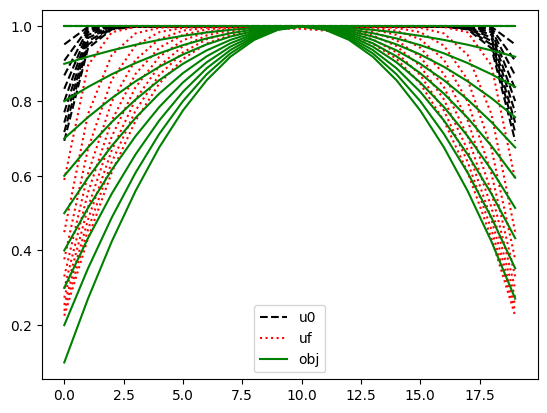

In [ ]:
import os
import jax.numpy as jnp
os.chdir('../src')
from state import Grid
from case import Case
from model import State, Trajectory
from fitter import Fitter, FittableParameter, FittableParametersSet
import matplotlib.pyplot as plt
import xarray as xr

# experience
nz = 20
g = Grid.linear(nz, 200)
u0 = jnp.ones(nz)
state0 = State(g, u0)

nt = 50
out_dt = 5.
dt = 1.
case = Case(1.)

# observation
n_out = int(nt*dt/out_dt)
x = jnp.arange(nz)
u_obs_f = -4*x*(x-nz)/(nz**2)
u_obs_time_list = [i/n_out*(u_obs_f-1)+1 for i in range(n_out)]
u_obs = jnp.vstack(u_obs_time_list)
obs = Trajectory(g, jnp.arange(n_out), u_obs)

# fitter
alpha_par = FittableParameter(True, min_bound=0., max_bound=10., init_val=1.)
beta_par = FittableParameter(False, fixed_val=1.)
coef_fit_params = FittableParametersSet({'alpha': alpha_par, 'beta': beta_par})
nloop = 100
learning_rate = 1.
verbatim = True


f = Fitter(coef_fit_params, nloop, nt, dt, out_dt, g, state0, case, obs, learning_rate, verbatim)

clo_parf = f()

f.plot_res(clo_parf)


In [ ]:
f.plot_res(clo_parf)


TypeError: Model.__init__() missing 1 required positional argument: 'vertical_physics'

# Example of optimisation loop
The same as previous section but with the exhibition of the loop

In [ ]:
import os
import optax
import jax.numpy as jnp
from jax import grad
os.chdir('../src')
from state import Grid
from case import Case
from model import State, Model
from fitter import FittableParameter, FittableParametersSet


# experience
nz = 20
g = Grid.linear(nz, 200)
u0 = jnp.ones(nz)
state0 = State(g, u0)

nt = 50
dt = 1.
case = Case(1.)

# observation
x = jnp.arange(nz)
u_obs = -4*x*(x-nz)/(nz**2)
state_obs = State(g, u_obs)

# fitter
alpha_par = FittableParameter(True, min_bound=0., max_bound=10., init_val=1.)
beta_par = FittableParameter(False, fixed_val=1.)
coef_fit_params = FittableParametersSet({'alpha': alpha_par, 'beta': beta_par})
nloop = 50
learning_rate = 1.
verbatim = True


def loss(x):
    vertical_physic = coef_fit_params.fit_to_closure(x)
    model = Model(nt, dt, g, state0, case, vertical_physic)
    sf = model()
    return sf.cost(state_obs)


optimizer = optax.adam(learning_rate)
x = coef_fit_params.gen_init_val()
opt_state = optimizer.init(x)
for i in range(nloop):
    grads = grad(loss)(x)
    updates, opt_state = optimizer.update(grads, opt_state)
    x = optax.apply_updates(x, updates)
    print(f"""
        loop {i}
        x {x}
        grads {grads}
    """)

Matplotlib is building the font cache; this may take a moment.



        loop 0
        x [1.9999933]
        grads [-0.8074703]
    

        loop 1
        x [2.964122]
        grads [-0.51076]
    

        loop 2
        x [3.8904946]
        grads [-0.37203768]
    

        loop 3
        x [4.779022]
        grads [-0.29023492]
    

        loop 4
        x [5.6302776]
        grads [-0.23580271]
    

        loop 5
        x [6.4451113]
        grads [-0.19683094]
    

        loop 6
        x [7.2245054]
        grads [-0.16752549]
    

        loop 7
        x [7.9695253]
        grads [-0.14469998]
    

        loop 8
        x [8.681275]
        grads [-0.12644525]
    

        loop 9
        x [9.360882]
        grads [-0.11154085]
    

        loop 10
        x [10.009479]
        grads [-0.09916799]
    

        loop 11
        x [10.628199]
        grads [-0.08875466]
    

        loop 12
        x [11.21817]
        grads [-0.07988873]
    

        loop 13
        x [11.780507]
        grads [-0.07226505]
    

        lo

In [ ]:

import numpy as np
np.arange(1000)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# Testing speed for filling the history tab

In [ ]:
import os
import jax.numpy as jnp
os.chdir('../src')
from grid import Grid
from case import Case
from model import State, Model, VerticalPhysics



# experience
nz = 100
g = Grid.linear(nz, 200)
u0 = jnp.ones(nz)
state0 = State(g, u0, u0, u0, u0)

nt = 50
n_out = 10
dt = 1.
case = Case(1.)


vertical_physic = VerticalPhysics(1, 1)

model = Model(nt, dt, n_out, g, state0, case, vertical_physic)

%time model()

model()


model.set_initial_state(state0)

CPU times: user 49.7 ms, sys: 495 μs, total: 50.1 ms
Wall time: 50.7 ms


FrozenInstanceError: cannot assign to field 'state0'

nz 100, nt 500, n_out=10
list/vmap 325 ms ± 2.92 ms
templissage tableau 342 ms ± 4.11 ms

nz 100, nt 5000, n_out=10
list/vmap 3.3 s ± 36.3 ms
remplissage tableau 3.33 s ± 39.6 ms

nz 1000, nt 500, n_out=10
list/vmap 327 ms ± 3.82 ms
templsisage 336 ms ± 2.01 ms


les temps semblent très similaires sans jitification

In [ ]:
import jax.numpy as jnp
from jax import jit
from time import time as tt

@jit
def f(u): return 1.01*u

nz = 10000
nt = 1000


u = jnp.ones(nz)
t = tt()
h = jnp.zeros([nt, nz])
for i in range(nt):
    h = h.at[i, :].set(u)
    u = f(u)
print(tt()-t)

u = jnp.ones(nz)
t = tt()
hl = []
for i in range(nt):
    hl.append(u)
    u = f(u)
hh = jnp.vstack(hl)
print(tt()-t)

jnp.all(h == hh)

1.864612102508545
0.09425687789916992


Array(True, dtype=bool)

la ca semble clair que le plus rapide est la technique de la liste

# Testing the model on Kato Philips

In [3]:
import os
import jax.numpy as jnp
os.chdir('../src')
import matplotlib.pyplot as plt
import numpy as np
from grid import Grid
from model import State, KepsParams, Model
from case import Case

grid = Grid.linear(10, 50)


state0 = State(grid)
state0 = state0.init_all()
state0 = state0.init_t(hmxl=0., t_sfc=16.)
state0 = state0.init_s(hmxl=100)
case = Case(lat=0., tflx_sfc_W=0., u_wind=1e-2) # KP

keps_params = KepsParams(c1=9.)

model = Model(1000, 30, 300, grid, state0, case)

history = model.run(keps_params)

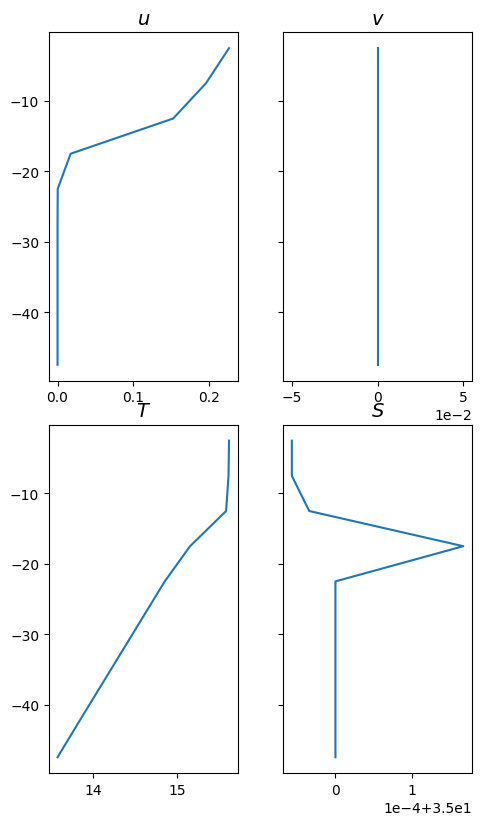

In [4]:

import matplotlib.pyplot as plt

fig, [[axu, axv], [axt, axs]] = plt.subplots(2, 2, sharey=True, figsize=(5, 8))

plt.tight_layout()

axu.set_title('$u$', fontsize=14)
axv.set_title('$v$', fontsize=14)
axt.set_title('$T$', fontsize=14)
axs.set_title('$S$', fontsize=14)

axu.ticklabel_format(style='sci', axis='x', scilimits=(-2, 3))
axv.ticklabel_format(style='sci', axis='x', scilimits=(-2, 3))
axt.ticklabel_format(style='sci', axis='x', scilimits=(-2, 3))
axs.ticklabel_format(style='sci', axis='x', scilimits=(-2, 3))

axu.plot(history.u[-1, :], history.grid.zr)
axv.plot(history.v[-1, :], history.grid.zr)
axt.plot(history.t[-1, :], history.grid.zr)
axs.plot(history.s[-1, :], history.grid.zr)

plt.show()

# Experience of prefect model
Try to fit K-eps based on an observation produced by the model. No temporal or spatial interpolation. On a kato philip case

In [2]:
import os
import jax.numpy as jnp
os.chdir('../src')
from grid import Grid
from case import Case
from model import State, KepsParams, SingleColumnModel, Trajectory
from fitter import Fitter, FittableParameter, FittableParametersSet
from database import ObsSet, Obs
import matplotlib.pyplot as plt
import xarray as xr
from typing import Callable


# KATO philipsn model
grid = Grid.linear(20, 50)
nt = 100
dt = 30.
out_dt = 30.
state0 = State(grid)
state0 = state0.init_all()
state0 = state0.init_t(hmxl=0., t_sfc=16.)
state0 = state0.init_s(hmxl=100)
case = Case(lat=0., tflx_sfc_W=0., u_wind=1e-2) # KP
model = SingleColumnModel(nt, dt, out_dt, grid, state0, case, 'k-epsilon')

# observation = modele Keps parfait
keps_params_obs = KepsParams()
trajectory_obs = model.run(keps_params_obs)
ds_obs = trajectory_obs.to_ds()
obs = Obs(ds_obs)
obs_set = ObsSet([obs])

# what to fit ?
c1_par = FittableParameter(True, min_bound=3., max_bound=10., init_val=7.)
coef_fit_params = FittableParametersSet({'c1': c1_par})

# loss function
def loss(model: Callable[[], Trajectory], obs_set: ObsSet):
    ds_obs = obs_set.observations[0].variables
    t_obs = jnp.array(ds_obs['t'])
    traj = model()
    return  jnp.sum((traj.t-t_obs)**2)

# fitter
nloop = 10
learning_rate = 1
verbatim = True
f = Fitter(coef_fit_params, nloop, model, obs_set, learning_rate, verbatim, loss)

# call the fitter
clo_parf = f()




                    loop 0
                    x [6.0001945]
                    grads [5.320702e-05]
                

                    loop 1
                    x [5.0060487]
                    grads [4.658597e-05]
                


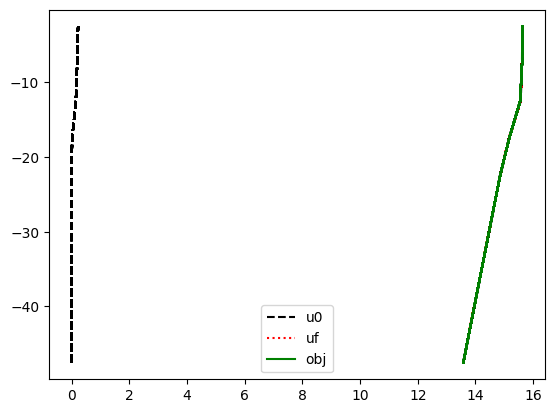

In [2]:
clo_parf = jnp.array([5.639618])

f.plot_res(clo_parf)

In [3]:
print(clo_parf)

[5.639618]


In [1]:
import xarray as xr
import jax.numpy as jnp
from jax import grad


def f(z: jnp.ndarray, ds: xr.Dataset):
    return jnp.sum((z-jnp.array(ds['u'].values))**2)

g = grad(f)

zz = jnp.arange(3, 13, dtype=jnp.float32)
u = jnp.arange(10)
x = jnp.arange(10)
dss = xr.Dataset({'u': ('x', u)}, {'x': x})

g(zz, dss)

Array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.], dtype=float32)

# Test des classes

In [19]:
import jax.numpy as jnp
import equinox as eqx
from abc import ABC, abstractmethod
from typing import Type, Callable, Tuple

class State(eqx.Module):
    u: jnp.ndarray
    diff: float

### Closure abstraction
class CloParAbs(eqx.Module, ABC):
    pass

class CloStateAbs(eqx.Module, ABC):
    @classmethod
    @abstractmethod
    def gen0(cls):
        pass

### Closure 1
class Clo1Par(eqx.Module):
    c1: float

class Clo1State(CloStateAbs):
    ad1: float

    @classmethod
    def gen0(cls):
        return cls(0.1)

def clo1_step(state: State, clo1_state: Clo1State, par: Clo1Par):
    c1 = par.c1
    ad1 = clo1_state.ad1
    new_clo1_state = Clo1State(ad1+c1)
    new_state = State(state.u, state.diff+new_clo1_state.ad1)
    return new_state, new_clo1_state

### Closure 2
class Clo2Par(eqx.Module):
    c2: float

class Clo2State(CloStateAbs):
    ad2: float

    @classmethod
    def gen0(cls):
        return cls(0.1)

def clo2_step(state: State, clo2_state: Clo2State, par: Clo2Par):
    c2 = par.c2
    ad2 = clo2_state.ad2
    new_clo2_state = Clo2State(ad2*c2)
    new_state = State(state.u, state.diff*new_clo2_state.ad2)
    return new_state, new_clo2_state

### Registre
clo_registre = {
    '1': {'clo_par_class': Clo1Par,
          'clo_state_class': Clo1State,
          'clo_step': clo1_step},
    '2': {'clo_par_class': Clo2Par,
          'clo_state_class': Clo2State,
          'clo_step': clo2_step}
}
### Model
class Model(eqx.Module):
    n: int
    clo_par_class: Type[CloParAbs]
    clo_state_class: Type[CloStateAbs]
    clo_step: Callable[[State, CloStateAbs, CloParAbs], Tuple[State, CloStateAbs]]
    
    def __init__(self, n: int, clo: str):
        self.n = n
        self.clo_par_class = clo_registre[clo]['clo_par_class']
        self.clo_state_class = clo_registre[clo]['clo_state_class']
        self.clo_step = clo_registre[clo]['clo_step']
    
    def step(self, state: State, state_clo: CloStateAbs, par: CloParAbs):
        state, state_clo = self.clo_step(state, state_clo, par)

        u = state.u+state.diff
        
        state = State(u, state.diff)
        return state, state_clo

    def run(self, state0: State, par: CloParAbs):
        state = state0
        state_clo = self.clo_state_class.gen0()
        for _ in range(self.n):
            state, state_clo = self.step(state, state_clo, par)
        return state


m = Model(10, '1')

s0 = State(jnp.zeros(5), 1)

par1 = Clo1Par(0.1)
par2 = Clo2Par(0.1)

fs = m.run(s0, par1)
fs.u


Array([37.5, 37.5, 37.5, 37.5, 37.5], dtype=float32)

qodifubnu  
qdofbndof
qdofibjdf
odfnb  
oqdkfboqd

# Exploration dtabase ramadan

In [5]:
import netCDF4 as nc

dataset = nc.Dataset('../obs/193_wily-20240625T1326Z/les-april_2010.no_stokes.nc', mode='r')

# Afficher des informations générales sur le fichier
print("Informations générales du fichier NetCDF :")
print(dataset)

# Explorer les dimensions
print("\nDimensions :")
for dim in dataset.dimensions.values():
    print(f"  {dim.name}: {dim.size}")

# Explorer les variables
print("\nVariables :")
for var in dataset.variables.values():
    print(f"  {var.name}: {var.dimensions} (shape: {var.shape})")

# Explorer les attributs globaux
print("\nAttributs globaux :")
for attr in dataset.ncattrs():
    print(f"  {attr}: {dataset.getncattr(attr)}")

# Explorer les attributs des variables
print("\nAttributs des variables :")
for var_name in dataset.variables:
    var = dataset.variables[var_name]
    print(f"\nVariable {var_name}:")
    for attr_name in var.ncattrs():
        print(f"  {attr_name}: {var.getncattr(attr_name)}")

# Fermer le fichier NetCDF
dataset.close()

Informations générales du fichier NetCDF :
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): time(101), nlev(512)
    variables(dimensions): float64 time(time), float64 zu(nlev), float64 zw(nlev), float64 lat(), float64 lon(), float64 alpha(), float64 beta(), float64 rho_a(), float64 rho_w(), float64 cp_a(), float64 cp_w(), float64 UVEL(time, nlev), float64 VVEL(time, nlev), float64 TEMP(time, nlev), float64 VTTF(time, nlev), float64 VTUF(time, nlev), float64 VTVF(time, nlev), float64 VTWF(time, nlev), float64 BB(time, nlev), float64 UU(time, nlev), float64 VV(time, nlev), float64 WWW(time, nlev), float64 USTKS(time, nlev), float64 VSTKS(time, nlev), float64 SP(time, nlev), float64 SP_ST(time, nlev), float64 TKE(time, nlev), float64 e(time, nlev), float64 DISSP(time, nlev), float64 ustar(time), float64 wbsfc(time), float64 u10(time), float64 v10(time), float64 cd10(time), float64 tau_x(time), float64 tau_y(time), flo

# Test pour découper le temps sur plusieurs simulations

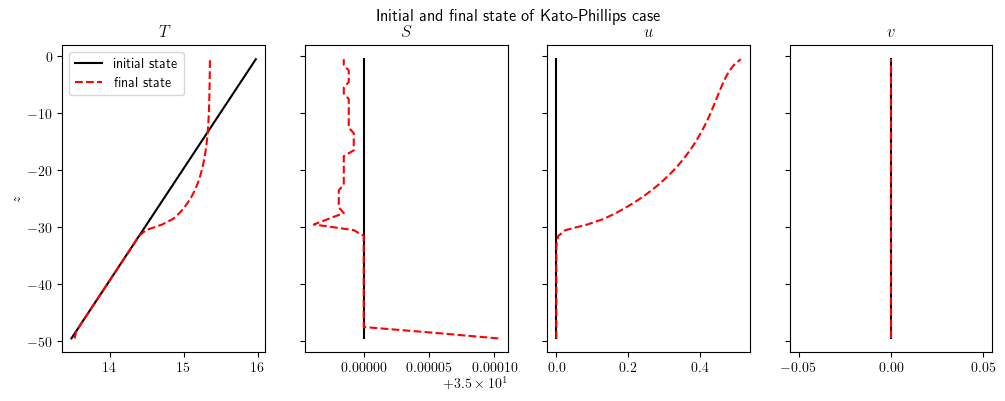

In [1]:
## General importations
import os
import jax.numpy as jnp

# add the source folder to import the Tunax modules
os.chdir('../src')

from grid import Grid
grid = Grid.linear(50, 50)

from model import State
state0 = State(grid)
state0 = state0.init_all()
state0 = state0.init_t(hmxl=0., t_sfc=16.)
state0 = state0.init_s(hmxl=100)

from case import Case
case = Case(lat=0., tflx_sfc_W=0., u_wind=1e-2)
case

from model import SingleColumnModel
nt = 360
dt = 300.
out_dt = 300.
model = SingleColumnModel(nt, dt, out_dt, grid, state0, case, 'k-epsilon')

from closures_registry import CLOSURES_REGISTRY
KepsParamsClass = CLOSURES_REGISTRY['k-epsilon'].parameters_class
keps_default_params = KepsParamsClass()
keps_default_params

trajectory_obs = model.compute_trajectory_with(keps_default_params)
trajectory_obs

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

zr = model.grid.zr

fig, [ax_t, ax_s, ax_u, ax_v] = plt.subplots(1, 4, sharey=True, figsize=(10, 4))
plt.tight_layout(rect=[0, 0.03, 1, 0.94])

ax_t.plot(trajectory_obs.t[0, :], zr, 'k', label='initial state')
ax_t.plot(trajectory_obs.t[-1, :], zr, 'r--', label='final state')
ax_s.plot(trajectory_obs.s[0, :], zr, 'k')
ax_s.plot(trajectory_obs.s[-1, :], zr, 'r--')
ax_u.plot(trajectory_obs.u[0, :], zr, 'k')
ax_u.plot(trajectory_obs.u[-1, :], zr, 'r--')
ax_v.plot(trajectory_obs.v[0, :], zr, 'k')
ax_v.plot(trajectory_obs.v[-1, :], zr, 'r--')

ax_t.set_title('$T$')
ax_s.set_title('$S$')
ax_u.set_title('$u$')
ax_v.set_title('$v$')

ax_t.set_ylabel('$z$')

ax_t.legend()

fig.suptitle('Initial and final state of Kato-Phillips case')

plt.show()

from database import ObsSet, Obs
ds_obs = trajectory_obs.to_ds()
obs = Obs(ds_obs)
obs_set = ObsSet([obs])

from fitter import FittableParameter, FittableParametersSet
c1_par = FittableParameter(True, min_bound=None, max_bound=None, init_val=15.)
coef_fit_params = FittableParametersSet({'c1': c1_par}, 'k-epsilon')




In [2]:

def loss(model, obs_set):
    ds_obs = obs_set.observations[0].variables
    t_obs = jnp.array(ds_obs['t'])
    traj = model()
    return jnp.sum((traj.t[-1, :]-t_obs[-1, :])**2)

from fitter import Fitter
nloop = 50
learning_rate = 1
verbatim = True
f = Fitter(coef_fit_params, nloop, model, obs_set, learning_rate, verbatim, loss)
clo_parf, x_history, grads_history = f.run_cut(12, trajectory_obs)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function loss_cut at /Users/admin-mouttaga/Codes/tunax/src/fitter.py:93 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/admin-mouttaga/Codes/tunax/src/closures/k_epsilon.py:66:13 (KepsParameters.__init__)

  operation a:f32[] = mul b c
    from line /Users/admin-mouttaga/Codes/tunax/src/closures/k_epsilon.py:152:11 (keps_step)

  operation a:f32[] = mul b c
    from line /Users/admin-mouttaga/Codes/tunax/src/closures/k_epsilon.py:153:11 (keps_step)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/admin-mouttaga/Codes/tunax/src/closures/k_epsilon.py:167:18 (keps_step)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/admin-mouttaga/Codes/tunax/src/closures/k_epsilon.py:171:7 (keps_step)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

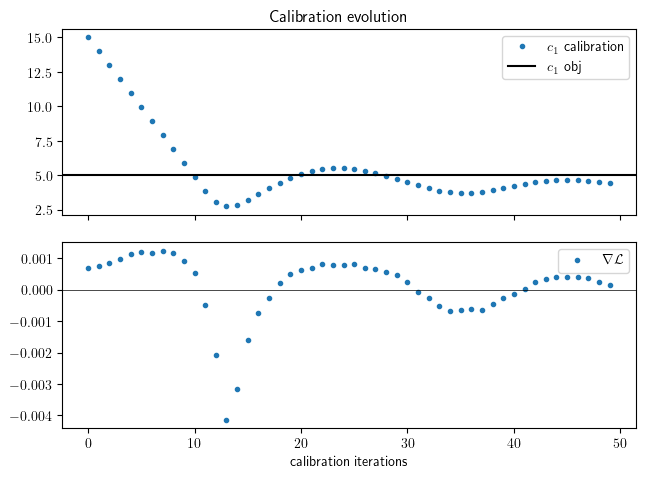

In [3]:
fig, [ax_x, ax_g] = plt.subplots(2, 1, sharex=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
ax_x.plot([x[0] for x in x_history], '.', label='$c_1$ calibration')
ax_x.axhline([5], color='k', label='$c_1$ obj')
ax_g.plot([g[0] for g in grads_history], '.', label=r'$\nabla \mathcal L$')
ax_g.axhline(0, color='k', linewidth=0.5)
ax_g.set_xlabel('calibration iterations')
ax_x.legend()
ax_g.legend()
fig.suptitle('Calibration evolution')
plt.show()

# Lire en direct l'optimisation

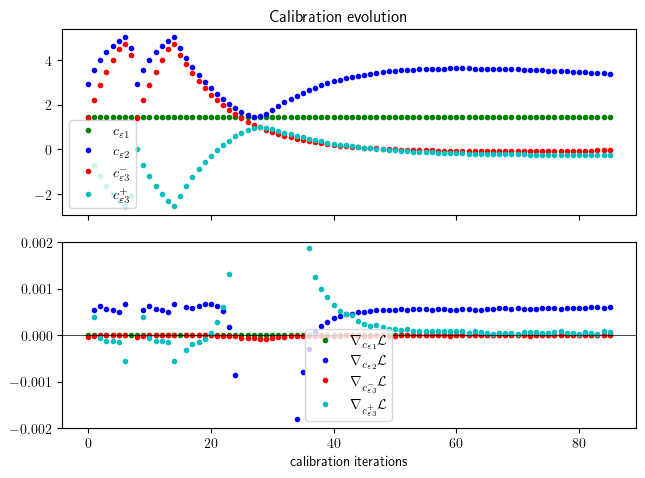

In [8]:
import os
import json
os.chdir('../src')
import matplotlib.pyplot as plt

with open('opti.json', 'r') as f:
    data = json.load(f)

c_eps1 = [float(x_i [0]) for x_i in data['x']]
c_eps2 = [float(x_i [1]) for x_i in data['x']]
c_eps3m = [float(x_i [2]) for x_i in data['x']]
c_eps3p = [float(x_i [3]) for x_i in data['x']]
grad_c_eps1 = [float(x_i [0]) for x_i in data['grad']]
grad_c_eps2 = [float(x_i [1]) for x_i in data['grad']]
grad_c_eps3m = [float(x_i [2]) for x_i in data['grad']]
grad_c_eps3p = [float(x_i [3]) for x_i in data['grad']]


fig, [ax_x, ax_g] = plt.subplots(2, 1, sharex=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
ax_x.plot(c_eps1, 'g.', label=r'$c_{\varepsilon 1}$')
ax_x.plot(c_eps2, 'b.', label=r'$c_{\varepsilon 2}$')
ax_x.plot(c_eps3m, 'r.', label=r'$c_{\varepsilon 3}^-$')
ax_x.plot(c_eps3p, 'c.', label=r'$c_{\varepsilon 3}^+$')
# ax_x.axhline([5], color='k', label='$c_1$ obj')
ax_g.plot(grad_c_eps1, 'g.', label=r'$\nabla_{c_{\varepsilon 1}} \mathcal L$')
ax_g.plot(grad_c_eps2, 'b.', label=r'$\nabla_{c_{\varepsilon 2}} \mathcal L$')
ax_g.plot(grad_c_eps3m, 'r.', label=r'$\nabla_{c_{\varepsilon 3}^-} \mathcal L$')
ax_g.plot(grad_c_eps3p, 'c.', label=r'$\nabla_{c_{\varepsilon 3}^+} \mathcal L$')
ax_g.axhline(0, color='k', linewidth=0.5)
ax_g.set_xlabel('calibration iterations')
ax_x.legend()
ax_g.legend()
fig.suptitle('Calibration evolution')
ax_g.set_ylim([-.002, .002])
plt.show()

6


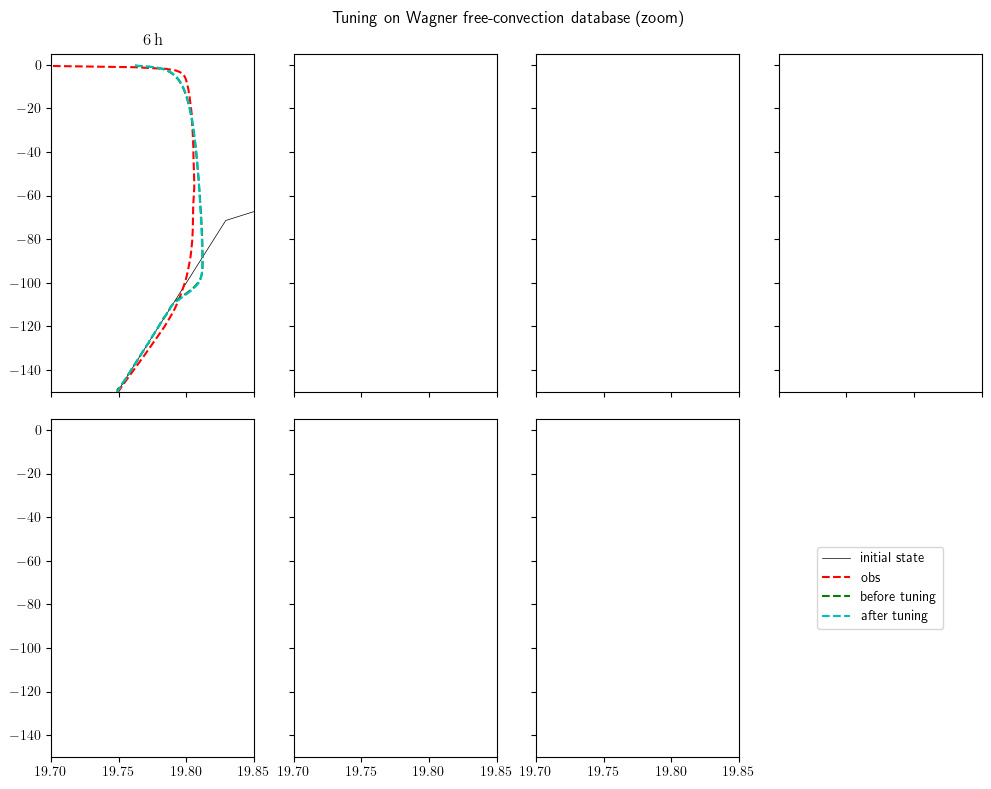

In [14]:
import os
os.chdir('../src')
from database import Obs
import equinox as eqx
from model import SingleColumnModel
from closures.k_epsilon import KepsParameters

var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}


dt = 10.
space_step = 1
forcing = 'free_convection'
timeframe_list = [6, 12, 18, 24, 36, 48, 72]
timeframe_list = timeframe_list[:1]

traj_wagner_list = []
traj_scm_init_list = []
traj_scm_tuned_list = []
for timeframe in timeframe_list:
    print(timeframe)
    filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
    filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

    obs = Obs.from_files(filename, filename_yaml, var_names)
    traj_wagner = obs.trajectory

    # inversion du flux
    obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

    # create model
    time_frame = float(traj_wagner.time[-1]/3600)
    out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
    init_state = traj_wagner.extract_state(0)
    model = SingleColumnModel(time_frame, dt, out_dt, traj_wagner.grid, init_state, obs.case, 'k-epsilon')

    # keps parameters
    keps_params_init = KepsParameters()
    keps_params_tuned = KepsParameters(c_eps1=c_eps1[0][-1], c_eps2=c_eps2[-1], c_eps3m=c_eps3m[-1], c_eps3p=c_eps3p[-1])

    # run models
    traj_scm_init = model.compute_trajectory_with(keps_params_init)
    traj_scm_tuned = model.compute_trajectory_with(keps_params_tuned)

    traj_wagner_list.append(traj_wagner)
    traj_scm_init_list.append(traj_scm_init)
    traj_scm_tuned_list.append(traj_scm_tuned)



zr = model.grid.zr
plt.rc('text', usetex=True)

fig, axes = plt.subplots(2, 4, sharey=True, sharex=True,figsize=(10, 8))
plt.tight_layout(rect=[0., 0., 1., .95])

axes_list = []
for axes_line in axes:
    for ax in axes_line:
        axes_list.append(ax)

for i_ax, time_frame in enumerate(timeframe_list):
    ax = axes_list[i_ax]
    traj_wagner = traj_wagner_list[i_ax]
    traj_scm_init = traj_scm_init_list[i_ax]
    traj_scm_tuned = traj_scm_tuned_list[i_ax]
    l_i, = ax.plot(traj_wagner.t[0, :], zr, 'k', linewidth=0.5)
    l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'r--')
    l_si, = ax.plot(traj_scm_init.t[-1, :], zr, 'g--')
    l_st, = ax.plot(traj_scm_tuned.t[-1, :], zr, 'c--')
    ax.set_title(rf'${timeframe} \, \mathrm h$')
    
axes_list[0].set_xlim([19.7, 19.85])
axes_list[0].set_ylim([-150, 5])

axes_list[-1].legend([l_i, l_w, l_si, l_st], ['initial state', 'obs', 'before tuning', 'after tuning'], loc='center')
axes_list[-1].axis('off')

fig.suptitle('Tuning on Wagner free-convection database (zoom)')

plt.show()


In [19]:
data

{'x': [[nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [1.440000057220459,
   2.919992446899414,
   1.3997119665145874,
   7.152557373046875e-06,
   5.999990463256836,
   1.7999930381774902,
   2.9679818153381348,
   2.1359894275665283,
   1.3999896049499512,
   4.950008869171143,
   1.5999842882156372,
   1.9999842643737793,
   -0.666692316532135,
   1.7199921607971191],
  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [1.440000057220459,
   2.0199992656707764,
   0.4999712109565735,
   0.9000006914138794,
   5.099998950958252,
   0.8999993205070496,
   2.067998170852661,
   1.2359989881515503,
   0.49999895691871643,
   5.850000858306885,
   0.6999984383583069,
   1.0999984741210938,
   0.23330076038837433,
   0.8199992179870605],
  [1.440000057220459,
   2.0990030765533447,
   0.5995679497718811,
   0.81594783

In [1]:
import os
import json
os.chdir('../src')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

with open('opti.json', 'r') as f:
    data = json.load(f)



coefs = [[float(x_i [i_c]) for x_i in data['x']] for i_c in range(len(data['x'][-1]))]
grads = [[float(x_i [i_c]) for x_i in data['grad']] for i_c in range(len(data['x'][-1]))]



fig, [ax_x, ax_g] = plt.subplots(2, 1, sharex=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
for c in coefs:
    ax_x.plot(c, '.')
for g in grads:
        ax_g.plot(g, '.')
ax_g.axhline(0, color='k', linewidth=0.5)
ax_g.set_xlabel('calibration iterations')
ax_x.legend()
ax_g.legend()
fig.suptitle('Calibration evolution')
ax_g.set_ylim([-.002, .002])
plt.show()

import os
os.chdir('../src')
from database import Obs
import equinox as eqx
from model import SingleColumnModel
from closures.k_epsilon import KepsParameters

var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': '',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}


dt = 10.
space_step = 1
forcing = 'free_convection'
timeframe_list = [6, 12, 18, 24, 36, 48, 72]
timeframe_list = timeframe_list[:1]

traj_wagner_list = []
traj_scm_init_list = []
traj_scm_tuned_list = []
for timeframe in timeframe_list:
    print(timeframe)
    filename = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
    filename_yaml = os.path.join('..', 'obs', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')

    obs = Obs.from_files(filename, filename_yaml, var_names)
    traj_wagner = obs.trajectory

    # inversion du flux
    obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

    # create model
    time_frame = float(traj_wagner.time[-1]/3600)
    out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
    init_state = traj_wagner.extract_state(0)
    model = SingleColumnModel(time_frame, dt, out_dt, traj_wagner.grid, init_state, obs.case, 'k-epsilon')

    # keps parameters
    keps_params_init = KepsParameters()
    keps_params_tuned = KepsParameters(
         c_eps1=coefs[0][-1], c_eps2=coefs[1][-1], c_eps3m=coefs[2][-1], c_eps3p=coefs[3][-1],
         c1=coefs[4][-1], c2=coefs[5][-1], c3=coefs[6][-1], c4=coefs[7][-1], c6=coefs[8][-1],
         cb1=coefs[9][-1], cb2=coefs[10][-1], cb3=coefs[11][-1], cb5=coefs[12][-1], cbb=coefs[13][-1])

    # run models
    traj_scm_init = model.compute_trajectory_with(keps_params_init)
    traj_scm_tuned = model.compute_trajectory_with(keps_params_tuned)

    traj_wagner_list.append(traj_wagner)
    traj_scm_init_list.append(traj_scm_init)
    traj_scm_tuned_list.append(traj_scm_tuned)



zr = model.grid.zr
plt.rc('text', usetex=True)

fig, axes = plt.subplots(2, 4, sharey=True, sharex=True,figsize=(10, 8))
plt.tight_layout(rect=[0., 0., 1., .95])

axes_list = []
for axes_line in axes:
    for ax in axes_line:
        axes_list.append(ax)

for i_ax, time_frame in enumerate(timeframe_list):
    ax = axes_list[i_ax]
    traj_wagner = traj_wagner_list[i_ax]
    traj_scm_init = traj_scm_init_list[i_ax]
    traj_scm_tuned = traj_scm_tuned_list[i_ax]
    l_i, = ax.plot(traj_wagner.t[0, :], zr, 'k', linewidth=0.5)
    l_w, = ax.plot(traj_wagner.t[-1, :], zr, 'r--')
    l_si, = ax.plot(traj_scm_init.t[-1, :], zr, 'g--')
    l_st, = ax.plot(traj_scm_tuned.t[-1, :], zr, 'c--')
    ax.set_title(rf'${timeframe} \, \mathrm h$')
    
axes_list[0].set_xlim([19.7, 19.85])
axes_list[0].set_ylim([-150, 5])

axes_list[-1].legend([l_i, l_w, l_si, l_st], ['initial state', 'obs', 'before tuning', 'after tuning'], loc='center')
axes_list[-1].axis('off')

fig.suptitle('Tuning on Wagner free-convection database (zoom)')

plt.show()


IndexError: list index out of range